In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [3]:
datasets = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage', 
    shuffle= True, 
    image_size= (IMAGE_SIZE, IMAGE_SIZE), 
    batch_size= BATCH_SIZE
)

Found 2475 files belonging to 2 classes.


In [4]:
class_names = datasets.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

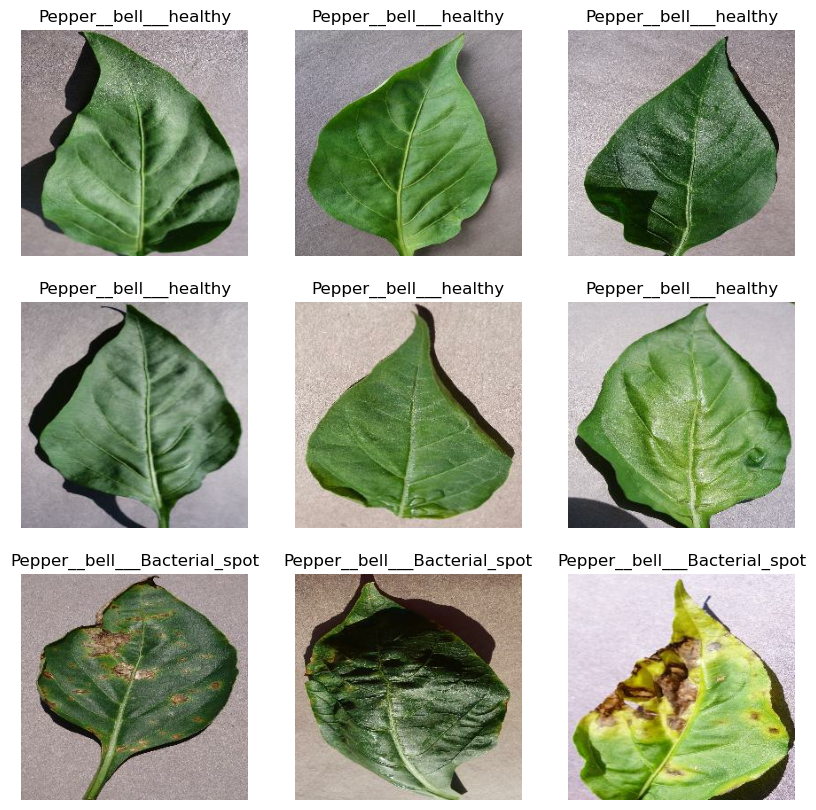

In [5]:
plt.figure(figsize= (10, 10))

for image_batch, label_batch in datasets.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [6]:
len(datasets)

78

In [7]:
78 * 32

2496

# train test split

80 % ====> training


20 % ====> 10 % ----> validation



           10 % ----> testing

In [8]:
train_size = 0.8
len(datasets) * train_size

62.400000000000006

In [9]:
train_ds = datasets.take(62)
len(train_ds)

62

In [10]:
test_ds = datasets.skip(62)
len(test_ds)

16

In [11]:
val_ds = test_ds.take(8)
len(val_ds)

8

In [12]:
test_ds = test_ds.skip(8)
len(test_ds)

8

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)  
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(datasets)

In [15]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

62
7
9


In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE), 
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [18]:
data_augmentaion = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'), 
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# build and train CNN model

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

In [20]:
model = models.Sequential([
    resize_and_rescale, 
    data_augmentaion, 
    layers.Conv2D(32, (3, 3), activation= 'relu', input_shape= input_shape), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(64, (3, 3), activation= 'relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(64, (3, 3), activation= 'relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(64, (3, 3), activation= 'relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Flatten(), 
    layers.Dense(64, activation= 'relu'), 
    layers.Dense(n_classes, activation= 'softmax')
])

model.build(input_shape= input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [22]:
model.compile(
    optimizer= 'adam', 
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits= False), 
    metrics= ['accuracy']
)

In [23]:
history = model.fit(
    train_ds, 
    validation_data= val_ds, 
    batch_size= BATCH_SIZE, 
    verbose= 1, 
    epochs= EPOCHS
)

Epoch 1/30
62/62 [==============================] - 75s 1s/step - loss: 0.5050 - accuracy: 0.7529 - val_loss: 0.1599 - val_accuracy: 0.9509
Epoch 2/30
62/62 [==============================] - 79s 1s/step - loss: 0.3158 - accuracy: 0.9022 - val_loss: 0.1361 - val_accuracy: 0.9464
Epoch 3/30
62/62 [==============================] - 85s 1s/step - loss: 0.2433 - accuracy: 0.9256 - val_loss: 0.1078 - val_accuracy: 0.9688
Epoch 4/30
62/62 [==============================] - 80s 1s/step - loss: 0.1763 - accuracy: 0.9480 - val_loss: 0.1551 - val_accuracy: 0.9420
Epoch 5/30
62/62 [==============================] - 79s 1s/step - loss: 0.1235 - accuracy: 0.9648 - val_loss: 0.0957 - val_accuracy: 0.9643
Epoch 6/30
62/62 [==============================] - 80s 1s/step - loss: 0.0846 - accuracy: 0.9801 - val_loss: 0.0099 - val_accuracy: 0.9955
Epoch 7/30
62/62 [==============================] - 80s 1s/step - loss: 0.0542 - accuracy: 0.9883 - val_loss: 0.0092 - val_accuracy: 1.0000
Epoch 8/30
62/62 [==

In [24]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 5s 332ms/step - loss: 0.0036 - accuracy: 1.0000


In [25]:
history

In [26]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 62}

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

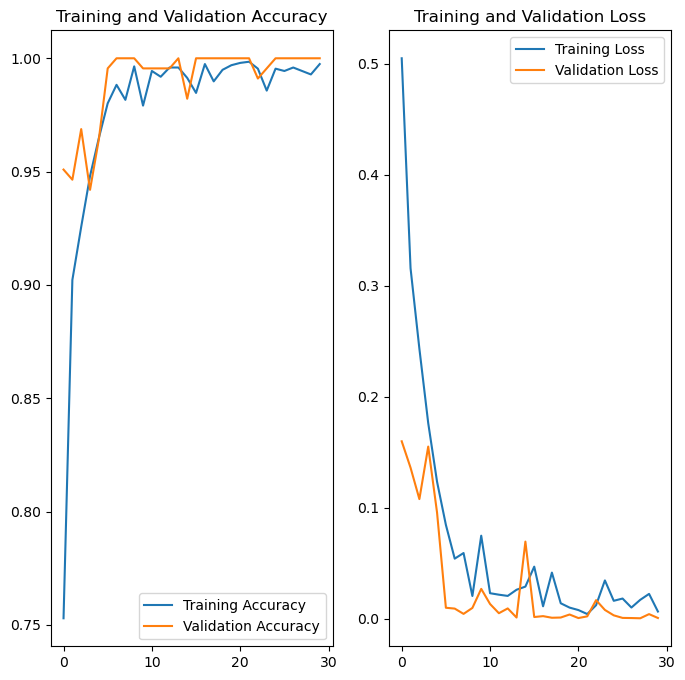

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
import numpy as np

first image to predict: 
Actual label:  Pepper__bell___Bacterial_spot
1/1 [==============================] - 1s 554ms/step
Predicted label:  Pepper__bell___Bacterial_spot


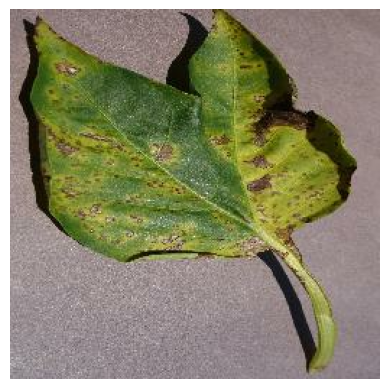

In [30]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print('first image to predict: ')
    plt.imshow(first_image)
    print('Actual label: ', class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print('Predicted label: ', class_names[np.argmax(batch_prediction[0])])
    plt.axis('off')

In [31]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(image_batch[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 40ms/step


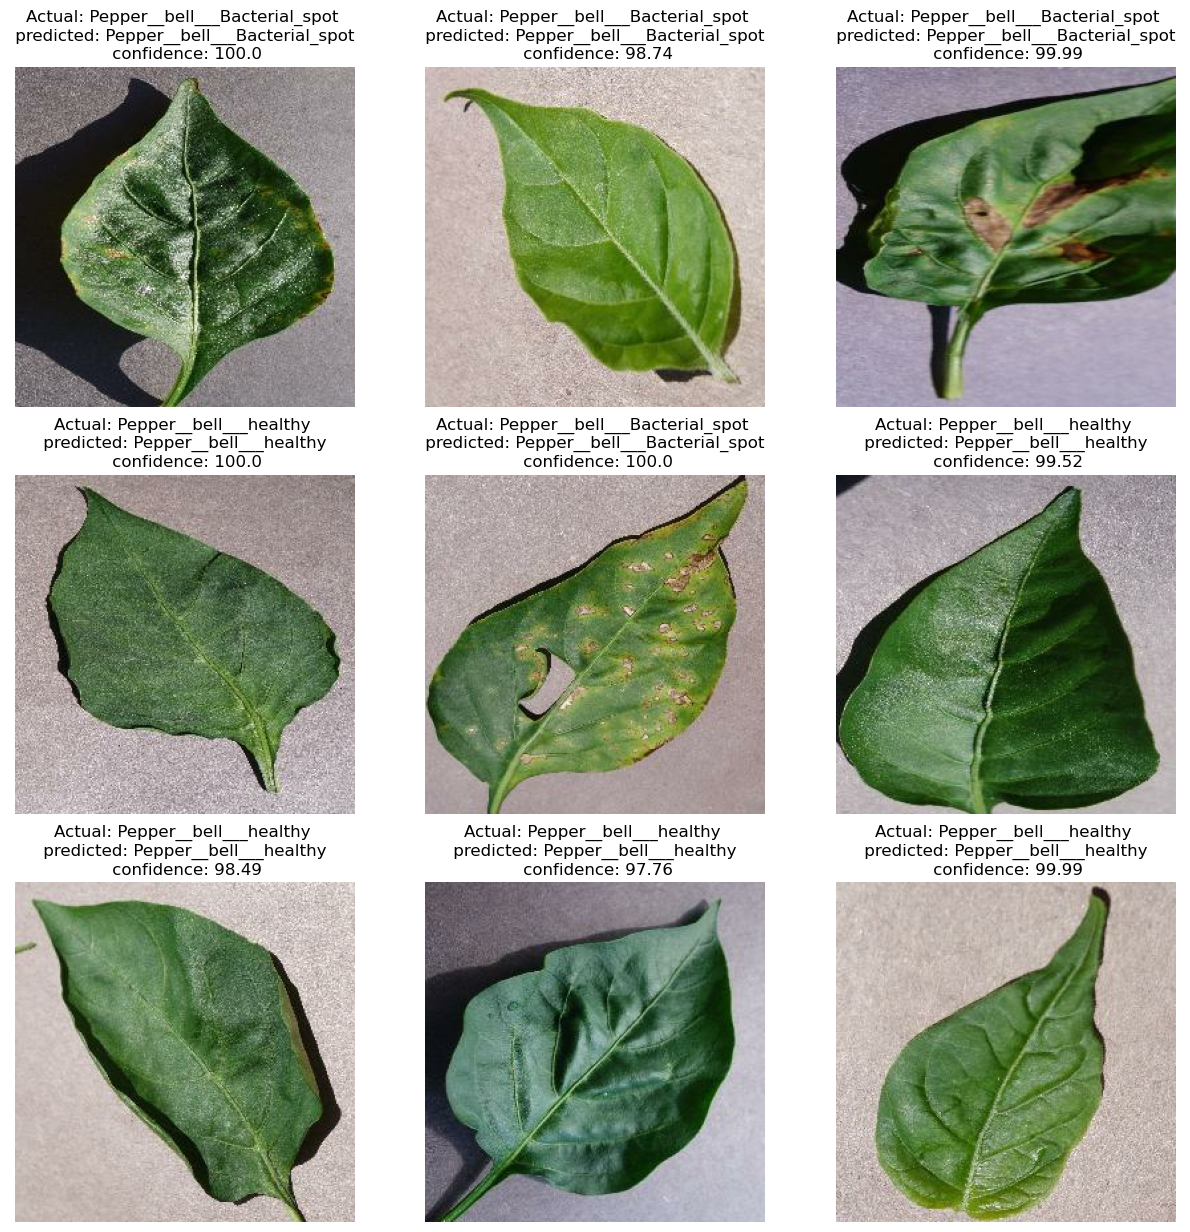

In [32]:
plt.figure(figsize= (15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax= plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[label_batch[i]]
        
        plt.title(f'Actual: {actual_class} \n predicted: {predicted_class} \n confidence: {confidence}')
        plt.axis('off')

In [33]:
import os
os.listdir('models')

['1']

In [34]:
model_version = max([int(i) for i in os.listdir('models') + [0]]) + 1
model.save(f'models/{model_version}')

INFO:tensorflow:Assets written to: models/2\assets


INFO:tensorflow:Assets written to: models/2\assets
